F:/seismic/models/brendan/*.pth
Loading:  F:/seismic/models/brendan\unet2d_caformer_seed3_epochbest.pt
n_models: 1


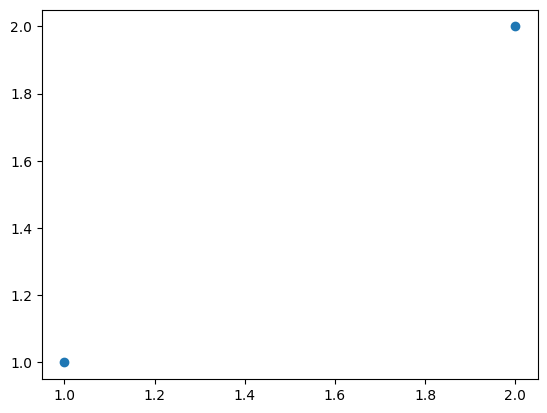

In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_forward
import pandas as pd
import seis_nn
from tqdm import tqdm
plt.scatter([1,2],[1,2])

In [2]:
data = kgs.load_all_train_data(validation_only=True)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [11:07<00:00,  4.50it/s]


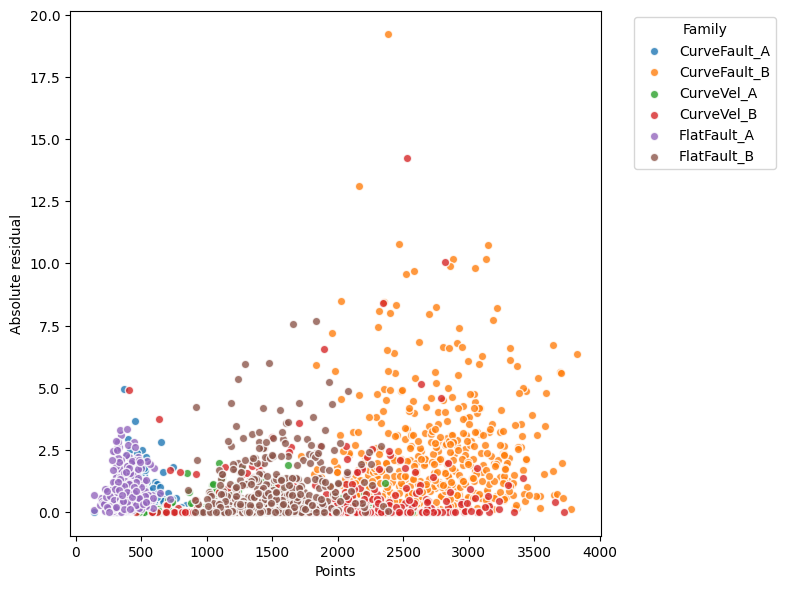

In [3]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.csgraph import connected_components

def label_thresholded_components(A: np.ndarray,
                                   X: float,
                                   connectivity: int = 4):
    """
    Label all components in A where two pixels are neighbors
    (4- or 8-connectivity) and their absolute difference ≤ X.
    
    Returns
    -------
    labels : np.ndarray of shape A.shape
        Integer labels 0…n_labels-1
    n_labels : int
        Number of connected components found
    """
    H, W = A.shape
    N = H*W

    # 1) build a sparse adjacency matrix of the grid
    adj = lil_matrix((N, N), dtype=bool)
    # choose neighbor offsets
    if connectivity == 4:
        neigh = [(1,0),(-1,0),(0,1),(0,-1)]
    else:  # 8-connectivity
        neigh = [(1,0),(-1,0),(0,1),(0,-1),
                 (1,1),(1,-1),(-1,1),(-1,-1)]

    # 2) for each pixel, connect to any neighbor whose diff ≤ X
    for i in range(H):
        for j in range(W):
            idx = i*W + j
            for di, dj in neigh:
                ni, nj = i+di, j+dj
                if 0 <= ni < H and 0 <= nj < W:
                    if abs(A[ni, nj] - A[i, j]) <= X:
                        adj[idx, ni*W + nj] = True

    # 3) find the connected components in that graph
    adj = adj.tocsr()
    n_labels, flat_labels = connected_components(adj,
                                                directed=False,
                                                return_labels=True)

    # 4) reshape back to H×W
    return flat_labels.reshape(H, W), n_labels

import cupy as cp
import cupyx.scipy.ndimage
#1/30
diff_threshold1 = 1.
diff_threshold2 = 30
def find_diff_points(mat):
    
    #print(np.unique(mat))
    plt.figure();plt.imshow(cp.asnumpy(mat))
    #plt.figure();plt.imshow(cp.asnumpy(mat))
    maxx = cupyx.scipy.ndimage.maximum_filter(mat,3)
    minn = -cupyx.scipy.ndimage.maximum_filter(-mat,3)
    diff = cp.maximum(cp.abs(mat-maxx), cp.abs(mat-minn))
    #result = cp.zeros(mat.shape, dtype=cp.uint16)
    #
    is_diff = (diff>diff_threshold).astype(cp.float64)
    diff_inds = cp.argwhere(cp.ravel(is_diff))
    result, max_ind = cupyx.scipy.ndimage.label(np.logical_not(is_diff))
    #print(result)
    result_flat = result.ravel()
    for i_ind, ind in enumerate(diff_inds):
        result_flat[ind[0]] = i_ind+max_ind+1
    #plt.figure();plt.imshow(cp.asnumpy(diff))
    #plt.imshow(0*mat.get()+1, cmap='gray', alpha=0.9-0.9*cp.asnumpy(is_diff))
    unique_vals, inv = np.unique(result_flat.get(), return_inverse=True)
    rng = np.random.default_rng(seed=0)
    shuffled_vals = rng.permutation(unique_vals)
    result_shuffled = shuffled_vals[inv].reshape(result.shape)
    
    plt.figure();plt.imshow(result_shuffled);plt.title(len(unique_vals)/4900)

def find_diff_points2(mat, pla=0):
    global ax
    if do_plots:
        plt.sca(ax[0+pla])
        plt.imshow(mat.get());
    labels,count = label_thresholded_components(mat.get(), diff_threshold1, connectivity=4)
    unique_vals, inv = np.unique(labels, return_inverse=True)
    rng = np.random.default_rng(seed=0)
    shuffled_vals = rng.permutation(unique_vals)
    result_shuffled = shuffled_vals[inv].reshape(mat.shape)
    if do_plots:
        plt.sca(ax[1+pla])
        plt.imshow(result_shuffled);#plt.title(len(unique_vals)/4900)

    maxx = cupyx.scipy.ndimage.maximum_filter(mat,3)
    minn = -cupyx.scipy.ndimage.maximum_filter(-mat,3)
    diff = cp.maximum(cp.abs(mat-maxx), cp.abs(mat-minn))
    is_diff = (diff>diff_threshold2)
    diff_inds = cp.argwhere(cp.ravel(is_diff)).get()


    labels = labels.ravel()
    for i_ind,ind in enumerate(diff_inds):
        labels[ind] = i_ind+count+1

    basis_functions = np.zeros((4900,count+len(diff_inds)+1), dtype=np.float64)    
    for ind in range(4900):
        basis_functions[ind,labels[ind]]=1.
    basis_functions = cp.array(basis_functions)
    basis_functions = basis_functions[:,cp.sum(basis_functions,axis=0)>0]

    return basis_functions

def evaluate(mat, basis_functions):
    fit = basis_functions@cp.linalg.solve(basis_functions.T@basis_functions, basis_functions.T@mat.ravel())
    residual = mat-cp.reshape(fit,(70,70))
    #global do_plots
    if do_plots:
        plt.sca(ax[4])
        plt.imshow(residual.get());plt.colorbar()        
    return cp.mean(cp.abs(residual))

do_plots = False
res = dict()
res['family'], res['guess_error'], res['residual'], res['points'] = [],[],[],[]
data_todo = data[:3000]
data_inferred = seis_nn.default_pretrained.infer(data_todo)
for d,di in tqdm(zip(data_todo,data_inferred), total=len(data_todo)):
   # if 'Fault_A' in d.family:
        #print('x')
   #     continue
    d.load_to_memory()
    #_,ax = plt.subplots(1,3,figsize=(12,4))
    mat = cp.array(di.velocity_guess.data)
    basis_functions = find_diff_points2(mat)
    res['residual'].append(evaluate(d.velocity.data, basis_functions).get())
    res['points'].append(basis_functions.shape[1])
    res['family'].append(d.family)
    res['guess_error'].append(cp.mean(cp.abs(mat-d.velocity.data)).get())
    d.unload()
    #if res['residual'][-1]/res['guess_error'][-1]>0.5:
    # if res['points'][-1]>2000:
    #     do_plots = True
    #     _,ax = plt.subplots(1,5,figsize=(20,4))
    #     find_diff_points2(d.velocity.data)
    #     plt.title('Correct')
    #     find_diff_points2(mat,pla=2)
    #     plt.title('Inferred')
    #     evaluate(d.velocity.data, basis_functions)
    #     plt.title(res['residual'][-1]/res['guess_error'][-1])
    #     plt.suptitle(d.cache_name())
    #     plt.pause(0.0001)
    #     do_plots= False
df = pd.DataFrame(res)
fig, ax = plt.subplots(figsize=(8,6))

for family, grp in df.groupby('family'):
    ax.scatter(
        grp['points'],
        grp['residual'],#/grp['guess_error'],
        label=family,
        #s=grp.get('points', 20),   # optional: scale marker size by ‘points’
        alpha=0.8,
        edgecolors='w'
    )

ax.set_xlabel('Points')
ax.set_ylabel('Absolute residual')
#ax.set_title('Guess Error vs. Residual by Family')
ax.legend(title='Family', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

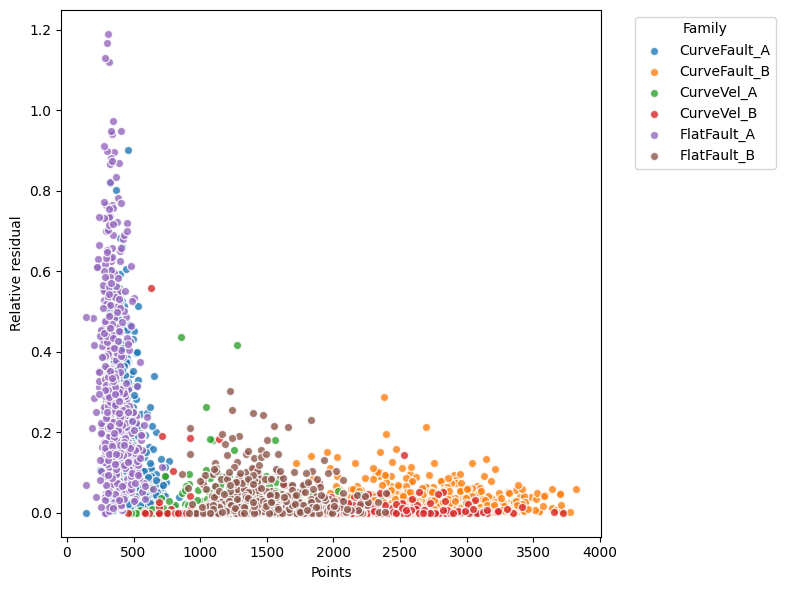

In [4]:
fig, ax = plt.subplots(figsize=(8,6))
for family, grp in df.groupby('family'):
    ax.scatter(
        grp['points'],
        grp['residual']/grp['guess_error'],
        label=family,
        #s=grp.get('points', 20),   # optional: scale marker size by ‘points’
        alpha=0.8,
        edgecolors='w'
    )

ax.set_xlabel('Points')
ax.set_ylabel('Relative residual')
#ax.set_title('Guess Error vs. Residual by Family')
ax.legend(title='Family', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
#plt.show()